In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from strategy import download, returns, historic_cumulative_returns

In [2]:
df = download(ticker = "TSLA", period = '60d', interval = '15m', prepost = True)

[*********************100%***********************]  1 of 1 completed


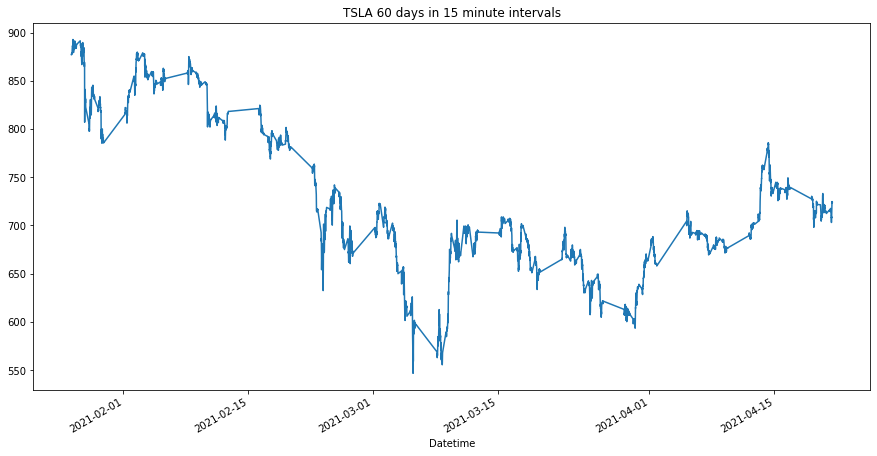

In [3]:
df.Close.plot(title = "TSLA 60 days in 15 minute intervals", figsize = (15,7.5))

In [4]:
df1, returns = returns(df)

In [5]:
returns

log_returns          826.048809
strategy_returns    1024.592546
dtype: float64

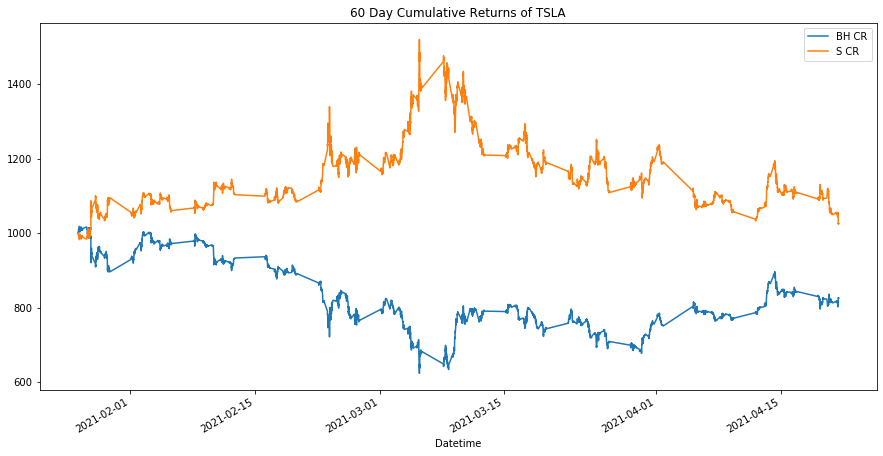

In [6]:
historic_cumulative_returns(df1).plot(figsize = (15,7.5), title = "60 Day Cumulative Returns of TSLA")

# Dataframe for the model

In [7]:
df = download(ticker = "TSLA", period = '2y', interval = '1d', prepost = False)

[*********************100%***********************]  1 of 1 completed


In [8]:
df = (df.Close).to_frame()

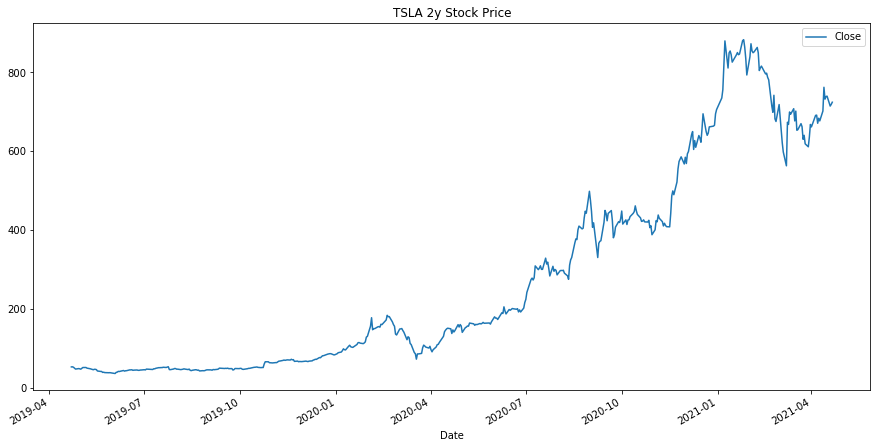

In [42]:
df.plot(title = 'TSLA 2y Stock Price', figsize = (15,7.5))

In [10]:
from statsmodels.tsa.arima_model import ARIMA

# Standardizing the data
We are doing this because we want to be able to run an ARMA model if we need to.

In [11]:
returns = df.Close.pct_change().dropna()

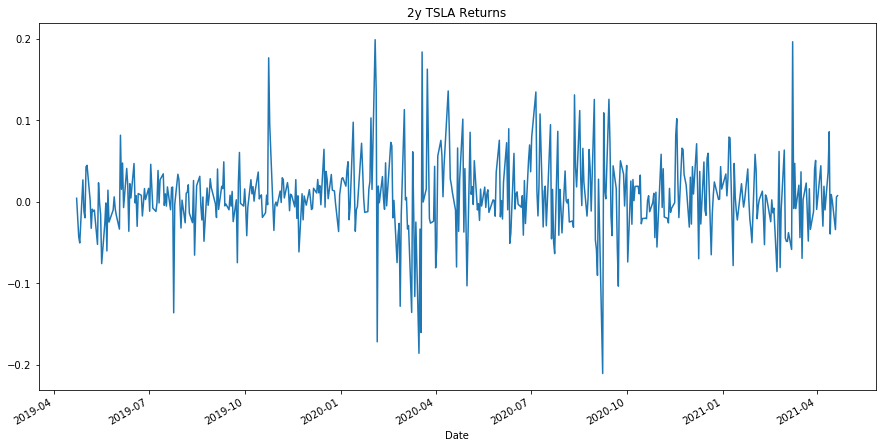

In [30]:
returns.plot(title = '2y TSLA Returns', figsize = (15,7.5))

# Running the Model On Train Data to find optimal order

In [43]:
best_order = []
for d in range(1,2):
    for q in range(1,3):
        for p in range(1,3):
            order = (p,d,q)
            # Estimate and ARMA model using statsmodels (use order=(2, 1))
            model = ARIMA(np.array(returns[:'2021-01']), order = order)

            # Fit the model and assign it to a variable called results
            results = model.fit()
            aic = results.aic
            order_results = [aic,order]
            best_order.append(order_results)
            print(order_results)

[-1447.998271006724, (1, 1, 1)]
[-1446.4162541777262, (2, 1, 1)]
[-1447.9917982251216, (1, 1, 2)]


/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


[-1445.4395063164814, (2, 1, 2)]


In [44]:
sorted(best_order)[0]
order = best_order[1][1]
order

(2, 1, 1)

# Running the model on test data

In [45]:
order = order
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARIMA(returns['2021-01':], order = order)

# Fit the model and assign it to a variable called results
results = model.fit()
results.summary()

/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/tyler/anaconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                   74
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 123.888
Method:                       css-mle   S.D. of innovations              0.044
Date:                Wed, 21 Apr 2021   AIC                           -237.775
Time:                        11:34:58   BIC                           -226.255
Sample:                             1   HQIC                          -233.180
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.995e-05      0.000     -0.349      0.727      -0.000       0.000
ar.L1.D.Close    -0.1232      0.116     -1.058      0.290      -0.351       0.105
ar.L2.D.Close    -0.0542      0.116     -0.469      0.639      -0.281       0.172
ma.L1.D.Close    -0.9999      0.074    -13.462      0.000      -1.146      -0.854
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1366           -4.1416j            4.2947           -0.2926
AR.2           -1.1366           +4.1416j            4.2947            0.2926
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

# This model had an AIC of -237 and a log liklihood which ended up being a positive number, which is pretty good.

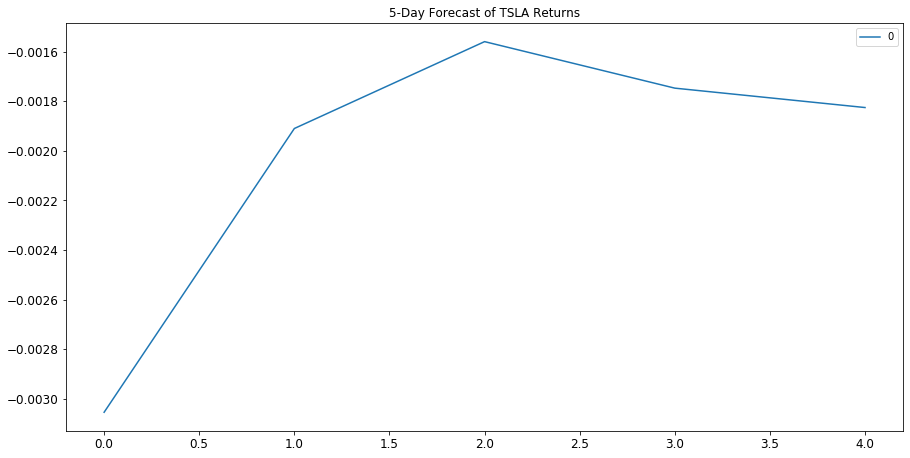

In [46]:
forecast1 = pd.DataFrame(results.forecast(steps =5)[0]).plot(
    title="5-Day Forecast of TSLA Returns",
    figsize = (15,7.5),
    fontsize = 'large'
    )
forecast1

In [47]:
forecast = pd.DataFrame(results.forecast(steps = 5)[0])

In [48]:
forecast = returns.append(forecast)

In [49]:
forecast.head()

,0
2019-04-23 00:00:00,0.004377
2019-04-24 00:00:00,-0.019856
2019-04-25 00:00:00,-0.042643
2019-04-26 00:00:00,-0.050438
2019-04-29 00:00:00,0.026920


In [50]:
forecast['CumProd'] = (1 + forecast.iloc[:,0]).cumprod() * df['Close'][0]

In [51]:
forecast

,0,CumProd
2019-04-23 00:00:00,0.004377,52.779999
2019-04-24 00:00:00,-0.019856,51.731998
2019-04-25 00:00:00,-0.042643,49.526001
2019-04-26 00:00:00,-0.050438,47.028000
2019-04-29 00:00:00,0.026920,48.293999
...,...,...
0,-0.003054,722.190873
1,-0.001910,720.811626
2,-0.001559,719.687575
3,-0.001747,718.430259


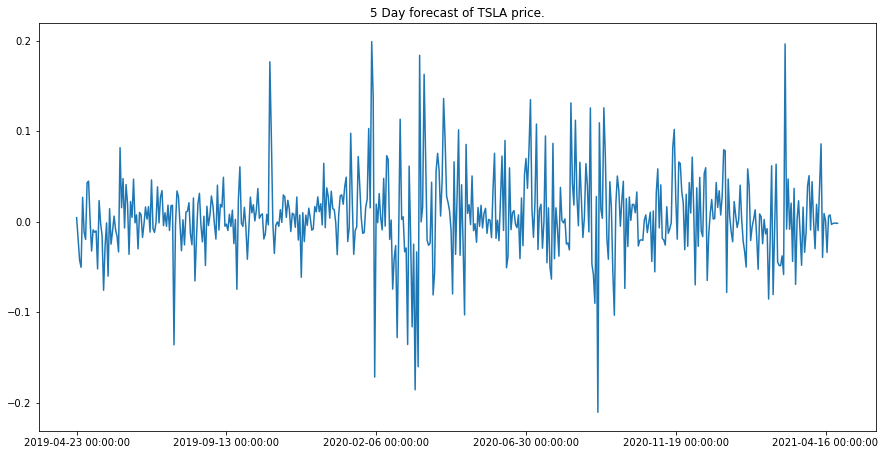

In [52]:
forecast.iloc[:,0].plot(figsize = (15,7.5), title = "5 Day forecast of TSLA price.")

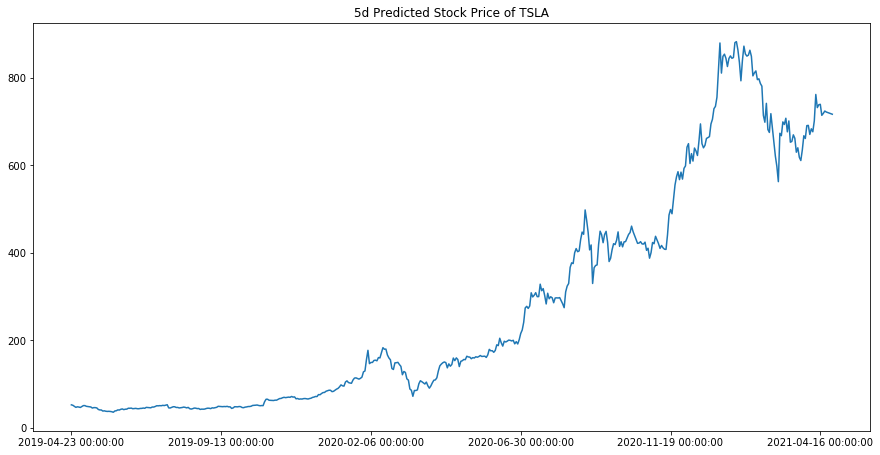

In [53]:
forecast['CumProd'].plot(title = '5d Predicted Stock Price of TSLA', figsize = (15,7.5))